In [24]:
import tensorflow as tf
import numpy as np
import utils.data_utils as du
import utils.model_helper as mh
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
DATASET_PATH = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset'
IMAGE_SHAPE = (150, 150, 3)
BATCH_SIZE = 8

In [3]:
(train_pairs, test_pairs) = du.make_train_test_pairs(DATASET_PATH, .1)
train_pairs.shape, test_pairs.shape

((316, 3, 150, 150, 3), (35, 3, 150, 150, 3))

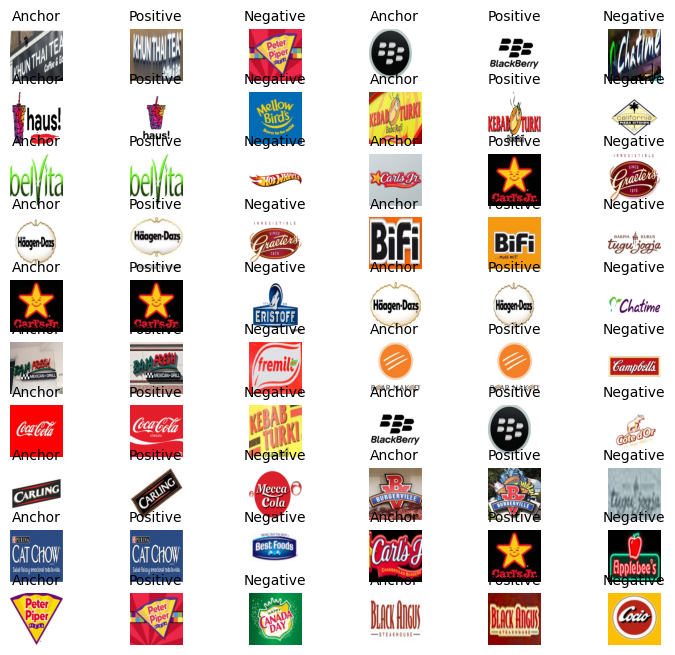

In [4]:
w = 9
h = 8

du.visualize(train_pairs, w, h)

In [5]:
base_cnn_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMAGE_SHAPE, weights='imagenet', include_top=False)

embedding_model = tf.keras.Sequential([
    base_cnn_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256),
], name='base_embedding_model')

trainable = False
for layer in base_cnn_model.layers:
    if layer.name == 'conv4_block2_out':
        trainable = True
    layer.trainable = trainable

2023-06-11 12:27:11.216894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 12:27:11.217372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    
anchor_input = tf.keras.layers.Input(name="anchor", shape=IMAGE_SHAPE)
positive_input = tf.keras.layers.Input(name="positive", shape=IMAGE_SHAPE)
negative_input = tf.keras.layers.Input(name="negative", shape=IMAGE_SHAPE)

distances = DistanceLayer()(
    embedding_model(tf.keras.applications.resnet.preprocess_input(anchor_input)),
    embedding_model(tf.keras.applications.resnet.preprocess_input(positive_input)),
    embedding_model(tf.keras.applications.resnet.preprocess_input(negative_input)),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [7]:
class SiameseModel(tf.keras.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [8]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam())
siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1], train_pairs[:, 2]],
                  epochs=10,
                  validation_data=[test_pairs[:, 0], test_pairs[:, 1], test_pairs[:, 2]]
                  )

Epoch 1/10
10/10 [==============================] - 45s 3s/step - loss: 3.8564 - val_loss: 0.2462
Epoch 2/10
10/10 [==============================] - 36s 4s/step - loss: 0.5108 - val_loss: 0.1470
Epoch 3/10
10/10 [==============================] - 34s 3s/step - loss: 0.4890 - val_loss: 0.1768
Epoch 4/10
10/10 [==============================] - 33s 3s/step - loss: 0.2939 - val_loss: 0.2682
Epoch 5/10
10/10 [==============================] - 34s 3s/step - loss: 0.3943 - val_loss: 0.1491
Epoch 6/10
10/10 [==============================] - 34s 3s/step - loss: 2.3046 - val_loss: 0.2538
Epoch 7/10
10/10 [==============================] - 34s 3s/step - loss: 0.3982 - val_loss: 0.2864
Epoch 8/10
10/10 [==============================] - 36s 4s/step - loss: 0.4129 - val_loss: 0.3606
Epoch 9/10
10/10 [==============================] - 33s 3s/step - loss: 0.5782 - val_loss: 0.3175
Epoch 10/10
10/10 [==============================] - 34s 3s/step - loss: 0.3659 - val_loss: 0.2086


In [71]:
anchor_path = '/home/irizqy/Downloads/ct_3.png'
target_path = '/home/irizqy/Downloads/franchise/jj.jpg'

anchor = mh.adjust_im(anchor_path, (150, 150)) 
target = mh.adjust_im(target_path, (150, 150))

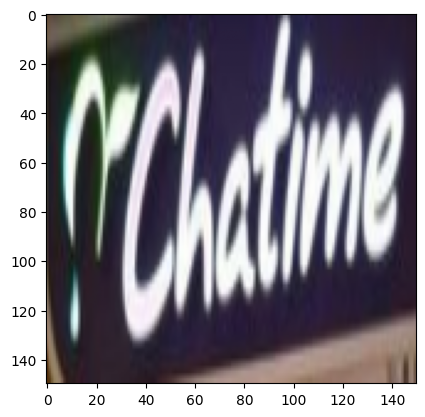

In [72]:
plt.imshow(anchor[0])

In [73]:
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(tf.keras.applications.resnet.preprocess_input(anchor)),
    embedding_model(tf.keras.applications.resnet.preprocess_input(target)),
    embedding_model(tf.keras.applications.resnet.preprocess_input(target)),
)

In [74]:
cosine_similarity = tf.keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

if positive_similarity > negative_similarity:
    print('positive')
else:    
    print('negative')

Positive similarity: 0.99988955
Negative similarity 0.9962458
positive
